# Lecture 11 スペクトル解析

音声ファイルのFFT

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import wave

def load_wav(filename, N):
    with wave.open(filename, 'r') as wav:
        fr = wav.getframerate()
        data = wav.readframes(N)
        s = np.frombuffer(data, dtype=np.int16)
        return s, fr

N = 16000
s, rate = load_wav('./data/note_g3.wav', N)


Text(0, 0.5, 'Gain')

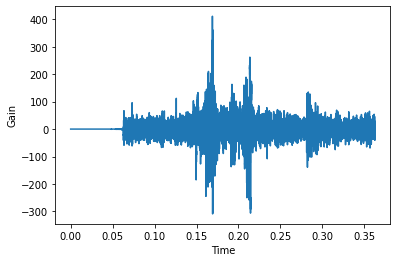

In [62]:
T = np.arange(0, N / rate, 1/ rate)
plt.plot(T, s)
plt.xlabel('Time')
plt.ylabel('Gain')

Text(0, 0.5, 'Power')

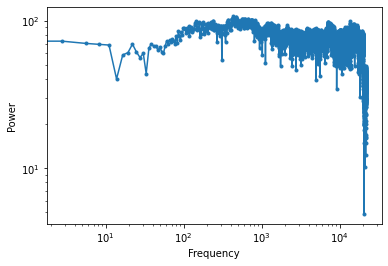

In [63]:
# フーリエ変換
fft_data = np.abs(np.fft.rfft(s))
freqList = np.fft.rfftfreq(len(s), 1.0 / rate)  # 横軸
plt.loglog(freqList, 10 * np.log(fft_data), '.-')
plt.xlabel('Frequency')
plt.ylabel('Power')


参考：[FFT を使った時系列データ解析](https://nykergoto.hatenablog.jp/entry/2019/07/09/FFT_%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E6%99%82%E7%B3%BB%E5%88%97%E3%83%87%E3%83%BC%E3%82%BF%E8%A7%A3%E6%9E%90)

python でフーリエ変換のモジュールというと有名なのは numpy.fft で基本的には

- fftn: 波形空間からフーリエ変換した強度空間への射影を行う関数
- ifftn: フーリエ変換された強度から元の波形空間へ戻す関数
- fftfreq: フーリエ変換した強度関数がどの周波数に対応しているかの周波数を計算する関数
の3つを使うことが多い印象です。 scipy のほうが早いらしいので変換がボトルネックになるような巨大データを扱うときは numpy からそちらに移行することも考えてみてください

In [1]:
import numpy as np
from numpy.fft import fftn, ifftn, fftfreq

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

output_dir = './fft_vis'
os.makedirs(output_dir, exist_ok=True)

def save_fig(fig, name):
    p = os.path.join(output_dir, name)
    print(f'save to {p}')
    fig.tight_layout()
    fig.savefig(p, dpi=120)

In [2]:
# データの総数
n_samples = 300

# 単位時間あたりに, いくつのデータ点が存在しているか. 
sampling_rate = 10
# サンプルデータ作成のために, 1 / sampling_rate ごとの等間隔な x を用意
x = np.arange(n_samples) / sampling_rate
# 作成した x を入力として, 周期 3 と 0.5 の波形 (+ノイズ) を足し合わせる.
y = np.sin(1 / 3 * 2 * np.pi * x) + .7 * np.sin(2 * 2 * np.pi * x) + .3 * np.random.normal(size=n_samples)

# あとでの遊びのために 10 のところでわざとピークをつける
y += np.where(x == 10, 5, 0)

Text(0.5, 1.0, 'Sample Time Series Data')

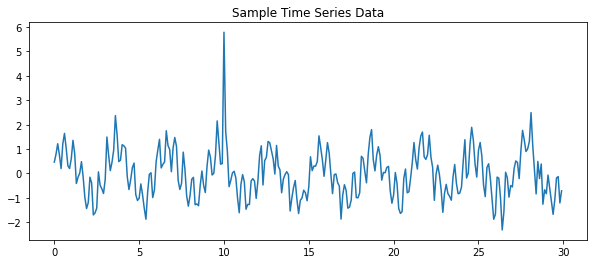

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y)

ax.set_title('Sample Time Series Data')

In [4]:
z = fftn(y)
freq = fftfreq(n_samples, d=1 / sampling_rate)

Text(0, 0.5, 'Power')

c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


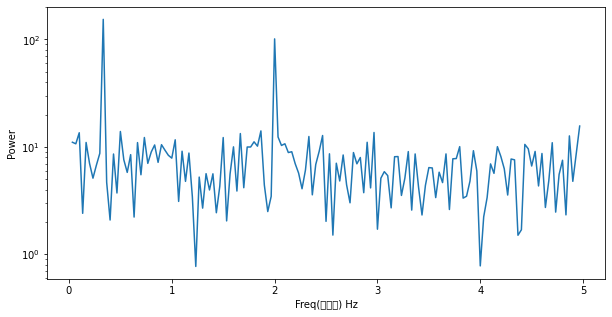

In [7]:
# ノリのような表示
# plt.plot(freq, abs(z))
#plt.yscale('log')
# 適当にやるとマイナスの周波数も表示される. +-で値は同じ(y軸対象)なのでプラス部分だけ可視化すれば十分
# 真面目に
fig, ax = plt.subplots(figsize=(10, 5), ncols=1, sharey=True)
ax.plot(freq[1:int(n_samples / 2)], abs(z[1:int(n_samples / 2)]))
ax.set_yscale('log')
ax.set_xlabel('Freq(周波数) Hz')
ax.set_ylabel('Power')

In [8]:
fft_pow_df = pd.DataFrame([1 / freq[1:int(n_samples / 2)], np.log10(abs(z[1:int(n_samples / 2)]))], index=['T', 'log10_power']).T
fft_pow_df.sort_values('log10_power', ascending=False).head(10)

,T,log10_power
9,3.000000,2.187323
59,0.500000,2.005645
148,0.201342,1.194102
55,0.535714,1.148809
14,2.000000,1.143491
88,0.337079,1.134093
2,10.000000,1.131773
49,0.600000,1.124259
73,0.405405,1.106030
145,0.205479,1.102598


save to ./fft_vis\sample_wave__ifft.png


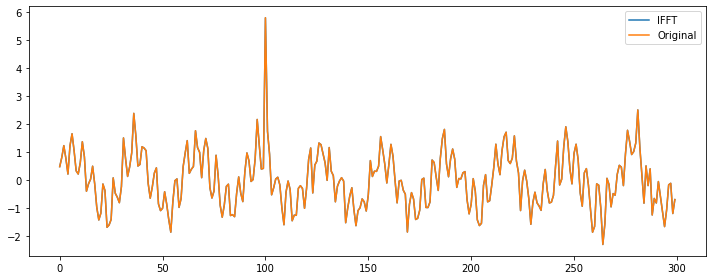

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ifftn(z).real, label='IFFT')
ax.plot(y, label='Original')
ax.legend()

save_fig(fig, name='sample_wave__ifft.png')

save to ./fft_vis\sample_wave__lowpass.png


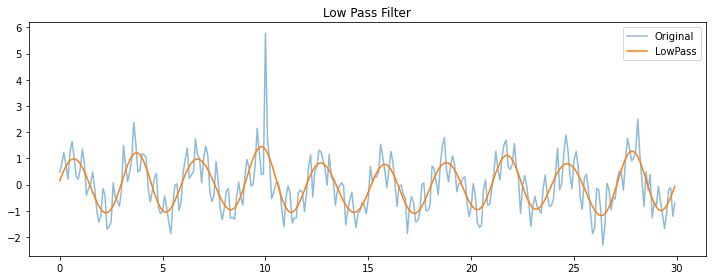

In [10]:
# 2以下の周期を無視する様な lowpass
threshold_period = 2
threshold_freq = 1 / threshold_period

z_lowpass = np.where(abs(freq) > threshold_freq, 0, z)
y_lowpass = ifftn(z_lowpass).real

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, '-', label='Original', alpha=.5)
ax.plot(x, y_lowpass, label='LowPass')
ax.set_title('Low Pass Filter')
ax.legend()

save_fig(fig, name='sample_wave__lowpass.png')